In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
file_name = 'tweets.csv'
headers = ['target', 'ids', 'date', 'flag', 'user', 'text']

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stopwords_list = stopwords.words('english')

random_state = 1234
test_size = 0.15
val_size = 0.15

oov_token = '<OOV>'
pad_token = '<PAD>'

batch_size = 128

In [3]:
def get_data(file_name):
    data = pd.read_csv(
                    file_name,
                    names=headers,
                    encoding='latin-1'
                    )
    data = data[['target', 'text']]
    data['target'] = data['target'].astype(int)
    data = data.dropna()
    return data

In [4]:
def vis_class_imbalance(data):
    target = data['target'].values
    counts = pd.Series(target).value_counts()
    sns.barplot(
            x=np.array(['negative','positive']),
            y=counts.values
               )  
    plt.title('Class Imbalance of Twitter Dataset')
    plt.xlabel('Sentiment')
    plt.xlabel('Counts')
    plt.savefig('imbalance.png')
    plt.show()

In [5]:
def lemmatization(lemmatizer,sentence):
    lem = [lemmatizer.lemmatize(k) for k in sentence]
    return [k for k in lem if k]

def remove_stop_words(stopwords_list,sentence):
    return [k for k in sentence if k not in stopwords_list]

def preprocess_one(tweet):
    tweet = tweet.lower()
    remove_punc = tokenizer.tokenize(tweet) # Remove puntuations
    remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
    remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
    lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
    remove_stop = remove_stop_words(stopwords_list,lemmatized) # remove stop words
    updated_tweet = ' '.join(remove_stop)
    return updated_tweet

def preprocessed_data(tweets):
    updated_tweets = []
    if isinstance(tweets, np.ndarray) or isinstance(tweets, list):
        for tweet in tweets:
            updated_tweet = preprocess_one(tweet)
            updated_tweets.append(updated_tweet)
    elif isinstance(tweets, np.str_)  or isinstance(tweets, str):
        updated_tweets = [preprocess_one(tweets)]

    return np.array(updated_tweets)

In [6]:
data = get_data(file_name)

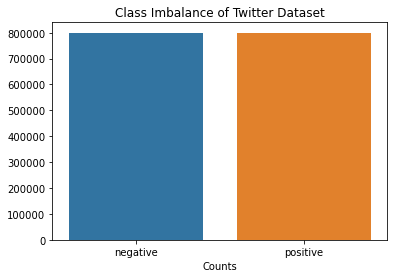

In [7]:
vis_class_imbalance(data)

In [10]:
tweets = data['text'].values
targets = data['target'].values

tweets, targets = shuffle(tweets, targets)

tweets = preprocessed_data(tweets)

X, X_test, Y, Y_test = train_test_split(
                                    tweets, 
                                    targets, 
                                    test_size=test_size, 
                                    random_state=random_state
                                    )

X, X_val, Y, Y_val = train_test_split(
                                    X, 
                                    Y, 
                                    test_size=val_size, 
                                    random_state=random_state
                                    )

print('Train Samples : {}'.format(len(Y)))
print('Val   Samples : {}'.format(len(Y_val)))
print('Test  Samples : {}'.format(len(Y_test)))

encoder = LabelEncoder()
encoder.fit(Y)

Y = encoder.transform(Y)
Y_val = encoder.transform(Y_val)
Y_test = encoder.transform(Y_test)

Train Samples : 1156000
Val   Samples : 204000
Test  Samples : 240000


In [11]:
def extract_vocabulary(X):
    vocab = {}
    for x in X:
        tokens = x.split(' ')
        for token in tokens:
            if token in vocab:
                vocab[token] += 1
            else:
                vocab[token] = 1
                
    vocab  = dict(
                sorted(
                    vocab.items(), 
                    key=lambda item: item[1], 
                    reverse=True
                       )
                )
    vocab = {token : idx+1 for idx, token in enumerate(list(vocab.keys()))}
    
    vocab[oov_token] = len(vocab) + 1
    vocab[pad_token] = 0
    
    print(f'The Size of the Vocabulary is {len(vocab)}')
    
    return vocab

def tokenize_data(tweets, vocab):
    sequences = []
    for tweet in tweets:
        tokens = tweet.split(' ')
        sequence = [vocab[token] if (token in vocab) else vocab[oov_token] for token in tokens]
        sequences.append(sequence)
    return sequences

def vis_length_variation(X_SEQ):
    X_len = [len(i) for i in X_SEQ]
    X_len = pd.Series(X_len)
    X_len.hist()
    plt.xlabel('Token Length')
    plt.ylabel('Samples')
    plt.savefig('sequence length.png')
    plt.show()
    
    print(X_len.describe())

In [12]:
vocab = extract_vocabulary(X)

The Size of the Vocabulary is 498465


In [13]:
X_SEQ = tokenize_data(X, vocab)
X_val_SEQ = tokenize_data(X_val, vocab)
X_test_SEQ = tokenize_data(X_test, vocab)

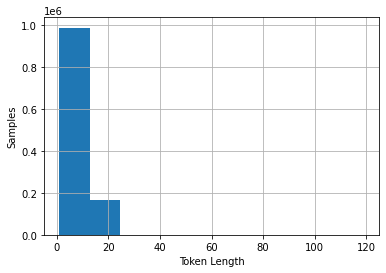

count    1.156000e+06
mean     7.783764e+00
std      4.112446e+00
min      1.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      1.190000e+02
dtype: float64


In [14]:
vis_length_variation(X_SEQ)

In [15]:
max_length = 110

In [16]:
def pad_tokens(sequences, max_length=max_length):
    seq_tensor = np.zeros((len(sequences), max_length))
    for idx, sequence in enumerate(sequences):
        if len(sequence) >= max_length:
            seq_tensor[idx, :] = np.array(sequence[:max_length])
        else:
            redundancy_length = max_length - len(sequence)
            padded_sequence = [vocab[pad_token]] * redundancy_length + sequence
            seq_tensor[idx, :] = np.array(padded_sequence)
            
    return seq_tensor

In [ ]:
X_PAD = pad_tokens(X_SEQ)
X_val_PAD = pad_tokens(X_val_SEQ)
X_test_PAD = pad_tokens(X_test_SEQ)

In [ ]:
X_PAD = X_PAD.astype(np.int32)
X_val_PAD = X_val_PAD.astype(np.int32)
X_test_PAD = X_test_PAD.astype(np.int32)

In [ ]:
X_PAD

In [ ]:
X_val_PAD

In [ ]:
X_test_PAD

In [ ]:
#Tensor Dataset
train_data = TensorDataset(
                    torch.from_numpy(X_PAD), 
                    torch.from_numpy(Y)
                            )

valid_data = TensorDataset(
                    torch.from_numpy(X_val_PAD), 
                    torch.from_numpy(Y_val)
                            )

test_data = TensorDataset(
                    torch.from_numpy(X_test_PAD), 
                    torch.from_numpy(Y_test)
                            )

# dataloaders
train_loader = DataLoader(
                    train_data, 
                    shuffle=True, 
                    batch_size=batch_size
                        )

valid_loader = DataLoader(
                    valid_data, 
                    shuffle=True, 
                    batch_size=batch_size
                        )

test_data = DataLoader(
                    test_data, 
                    shuffle=True, 
                    batch_size=batch_size
                        )

In [ ]:
# Check the Data Shapes of DataLoader Iteration

x_next, y_next = len(train_loader)

print('Input  Sample : \n{}'.format(x_next))
print('Output Sample : \n{}'.format(y_next))

In [ ]:
class SentimentAnalysis(nn.Module):
    def __init__(
                self, 
                vocab_size, 
                num_layers=2,
                embedding_dim=256,
                hidden_dim_lstm=256,
                hidden_dim_linear1=512,
                hidden_dim_linear2=256,
                hidden_dim_linear3=64,
                dropout_rate = 0.4
                ):
        super(SentimentAnalysis,self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(
                                input_size=embedding_dim,
                                hidden_size=hidden_dim_lstm,
                                num_layers=num_layers, 
                                batch_first=True
                                )
        
        self.dropout_layer = nn.Dropout(dropout_rate)

        self.linear_layer1 = nn.Linear(hidden_dim_linear1, hidden_dim_linear2)
        self.linear_layer2 = nn.Linear(hidden_dim_linear2, hidden_dim_linear3)
        self.linear_layer3 = nn.Linear(hidden_dim_linear3, 1)
        
        self.output_layer = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
